## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [20]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [21]:
train, test = keras.datasets.cifar10.load_data()

In [22]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [23]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [24]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [25]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [26]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.9,0.5,0.1]
redice_lr_patient = [3,5,10]

In [29]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor,
                                  min_lr=1e-12,
                                  monitor='val_loss',
                                  patience=reduce_patient,
                                  verbose=1
                                 )
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.90, reduce_patient: 3
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_13 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_14 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3072 - accuracy: 0.5461 - val_loss: 1.4787 - val_accuracy: 0.4757
Epoch 12/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2819 - accuracy: 0.5549 - val_loss: 1.4729 - val_accuracy: 0.4810
Epoch 13/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2602 - accuracy: 0.5628 - val_loss: 1.4664 - val_accuracy: 0.4821
Epoch 14/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.2383 - accuracy: 0.5703 - val_loss: 1.4676 - val_accuracy: 0.4861
Epoch 15/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.2170 - accuracy: 0.5789 - val_loss: 1.4551 - val_accuracy: 0.4843
Epoch 16/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1976 - accuracy: 0.5863 - val_loss: 1.4679 - val_accuracy: 0.4833
Epoch 17/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.1775 - accuracy: 0.5935 - val_

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 3s 55us/step - loss: 2.2498 - accuracy: 0.2623 - val_loss: 2.1558 - val_accuracy: 0.1961
Epoch 2/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.7690 - accuracy: 0.3810 - val_loss: 1.9838 - val_accuracy: 0.2748
Epoch 3/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.6436 - accuracy: 0.4232 - val_loss: 1.8484 - val_accuracy: 0.3491
Epoch 4/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5734 - accuracy: 0.4491 - val_loss: 1.7382 - val_accuracy: 0.3937
Epoch 5/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.5200 - accuracy: 0.4682 - val_loss: 1.6570 - val_accuracy: 0.4180
Epoch 6/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.4737 - accuracy: 0.4854 - val_loss: 1.6060 - val_accuracy: 0.4334
Epoch 7/25
50000/50000 [==============================] - 2s 49us/st

Epoch 21/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.1131 - accuracy: 0.6157 - val_loss: 1.4541 - val_accuracy: 0.4872
Epoch 22/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0954 - accuracy: 0.6230 - val_loss: 1.4405 - val_accuracy: 0.4972
Epoch 23/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.0764 - accuracy: 0.6298 - val_loss: 1.4462 - val_accuracy: 0.4929
Epoch 24/25
50000/50000 [==============================] - 2s 48us/step - loss: 1.0606 - accuracy: 0.6354 - val_loss: 1.4396 - val_accuracy: 0.4968
Epoch 25/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.0423 - accuracy: 0.6419 - val_loss: 1.4413 - val_accuracy: 0.5025
Numbers of exp: 5, reduce_factor: 0.50, reduce_patient: 10
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4703 - accuracy: 0.4845 - val_loss: 1.5823 - val_accuracy: 0.4474
Epoch 7/25
50000/50000 [==============================] - 3s 51us/step - loss: 1.4345 - accuracy: 0.4979 - val_loss: 1.5451 - val_accuracy: 0.4571
Epoch 8/25
50000/50000 [==============================] - 2s 49us/step - loss: 1.4002 - accuracy: 0.5094 - val_loss: 1.5259 - val_accuracy: 0.4613
Epoch 9/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3711 - accuracy: 0.5202 - val_loss: 1.5202 - val_accuracy: 0.4631
Epoch 10/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3453 - accuracy: 0.5297 - val_loss: 1.4953 - val_accuracy: 0.4728
Epoch 11/25
50000/50000 [==============================] - 2s 47us/step - loss: 1.3205 - accuracy: 0.5372 - val_loss: 1.4794 - val_accuracy: 0.4794
Epoch 12/25
50000/50000 [==============================] - 2s 46us/step - loss: 1.2968 - accuracy: 0.5480 - val_loss

50000/50000 [==============================] - 2s 47us/step - loss: 1.5524 - accuracy: 0.4540 - val_loss: 1.6534 - val_accuracy: 0.4284
Numbers of exp: 8, reduce_factor: 0.10, reduce_patient: 10
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_37 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_38 (Batc (None, 256)               1024      
_____________________________________________________________

50000/50000 [==============================] - 3s 52us/step - loss: 1.0138 - accuracy: 0.6456 - val_loss: 1.6949 - val_accuracy: 0.4235
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9593 - accuracy: 0.6640 - val_loss: 1.6974 - val_accuracy: 0.4230

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0008100000384729356.
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9021 - accuracy: 0.6863 - val_loss: 1.6692 - val_accuracy: 0.4433
Epoch 12/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.8595 - accuracy: 0.7033 - val_loss: 1.6803 - val_accuracy: 0.4464
Epoch 13/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.8290 - accuracy: 0.7131 - val_loss: 1.5846 - val_accuracy: 0.4684
Epoch 14/25
50000/50000 [==============================] - 3s 51us/step - loss: 0.7914 - accuracy: 0.7275 - val_loss: 1.8221 - val_accuracy: 0.4327
Epoch 15/25
50000/50000 [==================

50000/50000 [==============================] - 3s 50us/step - loss: 0.5347 - accuracy: 0.8255 - val_loss: 1.7311 - val_accuracy: 0.5064
Numbers of exp: 11, reduce_factor: 0.90, reduce_patient: 10
Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_46 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_47 (Batc (None, 256)               1024      
____________________________________________________________

50000/50000 [==============================] - 3s 52us/step - loss: 1.0780 - accuracy: 0.6226 - val_loss: 1.5127 - val_accuracy: 0.4667

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0001743392349453643.
Epoch 10/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.0035 - accuracy: 0.6506 - val_loss: 1.4325 - val_accuracy: 0.5020
Epoch 11/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9714 - accuracy: 0.6637 - val_loss: 1.3656 - val_accuracy: 0.5166
Epoch 12/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9450 - accuracy: 0.6730 - val_loss: 1.3607 - val_accuracy: 0.5242
Epoch 13/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.9203 - accuracy: 0.6814 - val_loss: 1.3947 - val_accuracy: 0.5116
Epoch 14/25
50000/50000 [==============================] - 3s 52us/step - loss: 0.8968 - accuracy: 0.6925 - val_loss: 1.3771 - val_accuracy: 0.5201
Epoch 15/25
50000/50000 [==================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 72us/step - loss: 1.9397 - accuracy: 0.3410 - val_loss: 2.1047 - val_accuracy: 0.2149
Epoch 2/25
50000/50000 [==============================] - 3s 57us/step - loss: 1.5884 - accuracy: 0.4431 - val_loss: 1.8899 - val_accuracy: 0.3588
Epoch 3/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4904 - accuracy: 0.4781 - val_loss: 1.7266 - val_accuracy: 0.4175
Epoch 4/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.4258 - accuracy: 0.5034 - val_loss: 1.6270 - val_accuracy: 0.4391
Epoch 5/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3774 - accuracy: 0.5188 - val_loss: 1.5761 - val_accuracy: 0.4525
Epoch 6/25
50000/50000 [==============================] - 3s 52us/step - loss: 1.3387 - accuracy: 0.5354 - val_loss: 1.5272 - val_accuracy: 0.4597
Epoch 7/25
50000/50000 [==============================] - 3s 52us/st

Epoch 21/25
50000/50000 [==============================] - 3s 55us/step - loss: 1.0252 - accuracy: 0.6521 - val_loss: 1.4391 - val_accuracy: 0.5017
Epoch 22/25
50000/50000 [==============================] - 3s 54us/step - loss: 1.0107 - accuracy: 0.6571 - val_loss: 1.4245 - val_accuracy: 0.5014
Epoch 23/25
50000/50000 [==============================] - 3s 53us/step - loss: 0.9966 - accuracy: 0.6636 - val_loss: 1.4366 - val_accuracy: 0.5012
Epoch 24/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.9827 - accuracy: 0.6693 - val_loss: 1.4145 - val_accuracy: 0.5075
Epoch 25/25
50000/50000 [==============================] - 3s 54us/step - loss: 0.9695 - accuracy: 0.6729 - val_loss: 1.4375 - val_accuracy: 0.5040
Numbers of exp: 16, reduce_factor: 0.10, reduce_patient: 5
Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)          

Epoch 6/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.3345 - accuracy: 0.5355 - val_loss: 1.5360 - val_accuracy: 0.4544
Epoch 7/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.3014 - accuracy: 0.5481 - val_loss: 1.5050 - val_accuracy: 0.4663
Epoch 8/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.2711 - accuracy: 0.5574 - val_loss: 1.4869 - val_accuracy: 0.4763
Epoch 9/25
50000/50000 [==============================] - 3s 61us/step - loss: 1.2418 - accuracy: 0.5709 - val_loss: 1.4812 - val_accuracy: 0.4779
Epoch 10/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.2159 - accuracy: 0.5795 - val_loss: 1.4628 - val_accuracy: 0.4805
Epoch 11/25
50000/50000 [==============================] - 3s 59us/step - loss: 1.1916 - accuracy: 0.5900 - val_loss: 1.4560 - val_accuracy: 0.4887
Epoch 12/25
50000/50000 [==============================] - 3s 60us/step - loss: 1.1703 - accuracy: 0.5961 - val_loss

Epoch 24/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.5376 - accuracy: 0.8199 - val_loss: 1.9331 - val_accuracy: 0.4455

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
Epoch 25/25
50000/50000 [==============================] - 3s 61us/step - loss: 0.4928 - accuracy: 0.8384 - val_loss: 1.8606 - val_accuracy: 0.4784
Numbers of exp: 19, reduce_factor: 0.90, reduce_patient: 5
Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_70 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Den

50000/50000 [==============================] - 3s 62us/step - loss: 1.2093 - accuracy: 0.5766 - val_loss: 1.7853 - val_accuracy: 0.3666
Epoch 7/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.1627 - accuracy: 0.5932 - val_loss: 1.6636 - val_accuracy: 0.4096
Epoch 8/25
50000/50000 [==============================] - 3s 63us/step - loss: 1.1163 - accuracy: 0.6117 - val_loss: 1.7467 - val_accuracy: 0.4063
Epoch 9/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0749 - accuracy: 0.6272 - val_loss: 1.5204 - val_accuracy: 0.4660
Epoch 10/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0384 - accuracy: 0.6394 - val_loss: 1.7250 - val_accuracy: 0.4008
Epoch 11/25
50000/50000 [==============================] - 3s 62us/step - loss: 1.0066 - accuracy: 0.6498 - val_loss: 1.5412 - val_accuracy: 0.4736
Epoch 12/25
50000/50000 [==============================] - 3s 62us/step - loss: 0.9649 - accuracy: 0.6681 - val_loss: 1.7863 - 

50000/50000 [==============================] - 3s 64us/step - loss: 0.7001 - accuracy: 0.7798 - val_loss: 1.3815 - val_accuracy: 0.5278
Epoch 24/25
50000/50000 [==============================] - 3s 64us/step - loss: 0.6962 - accuracy: 0.7806 - val_loss: 1.3780 - val_accuracy: 0.5313
Epoch 25/25
50000/50000 [==============================] - 3s 63us/step - loss: 0.6918 - accuracy: 0.7831 - val_loss: 1.3797 - val_accuracy: 0.5291

Epoch 00025: ReduceLROnPlateau reducing learning rate to 1.0896202184085269e-05.
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_28 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normali

50000/50000 [==============================] - 4s 71us/step - loss: 1.7943 - accuracy: 0.3773 - val_loss: 1.7987 - val_accuracy: 0.3591
Epoch 8/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.7560 - accuracy: 0.3901 - val_loss: 1.7715 - val_accuracy: 0.3746
Epoch 9/25
50000/50000 [==============================] - 4s 70us/step - loss: 1.7232 - accuracy: 0.4024 - val_loss: 1.7498 - val_accuracy: 0.3815
Epoch 10/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.6948 - accuracy: 0.4114 - val_loss: 1.7353 - val_accuracy: 0.3884
Epoch 11/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.6697 - accuracy: 0.4191 - val_loss: 1.7217 - val_accuracy: 0.3860
Epoch 12/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.6475 - accuracy: 0.4277 - val_loss: 1.7106 - val_accuracy: 0.3946
Epoch 13/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.6268 - accuracy: 0.4343 - val_loss: 1.6986 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 4s 85us/step - loss: 2.5955 - accuracy: 0.1707 - val_loss: 2.2488 - val_accuracy: 0.1633
Epoch 2/25
50000/50000 [==============================] - 3s 70us/step - loss: 2.2524 - accuracy: 0.2542 - val_loss: 2.1608 - val_accuracy: 0.2267
Epoch 3/25
50000/50000 [==============================] - 3s 69us/step - loss: 2.0902 - accuracy: 0.2951 - val_loss: 2.0722 - val_accuracy: 0.2719
Epoch 4/25
50000/50000 [==============================] - 4s 71us/step - loss: 1.9870 - accuracy: 0.3238 - val_loss: 1.9813 - val_accuracy: 0.3075
Epoch 5/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.9129 - accuracy: 0.3452 - val_loss: 1.9049 - val_accuracy: 0.3350
Epoch 6/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.8567 - accuracy: 0.3609 - val_loss: 1.8512 - val_accuracy: 0.3526
Epoch 7/25
50000/50000 [==============================] - 4s 70us/st

Epoch 21/25
50000/50000 [==============================] - 3s 67us/step - loss: 1.5240 - accuracy: 0.4686 - val_loss: 1.6539 - val_accuracy: 0.4228
Epoch 22/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.5119 - accuracy: 0.4734 - val_loss: 1.6473 - val_accuracy: 0.4278
Epoch 23/25
50000/50000 [==============================] - 3s 69us/step - loss: 1.4998 - accuracy: 0.4769 - val_loss: 1.6420 - val_accuracy: 0.4286
Epoch 24/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4881 - accuracy: 0.4817 - val_loss: 1.6337 - val_accuracy: 0.4296
Epoch 25/25
50000/50000 [==============================] - 3s 68us/step - loss: 1.4771 - accuracy: 0.4850 - val_loss: 1.6302 - val_accuracy: 0.4330


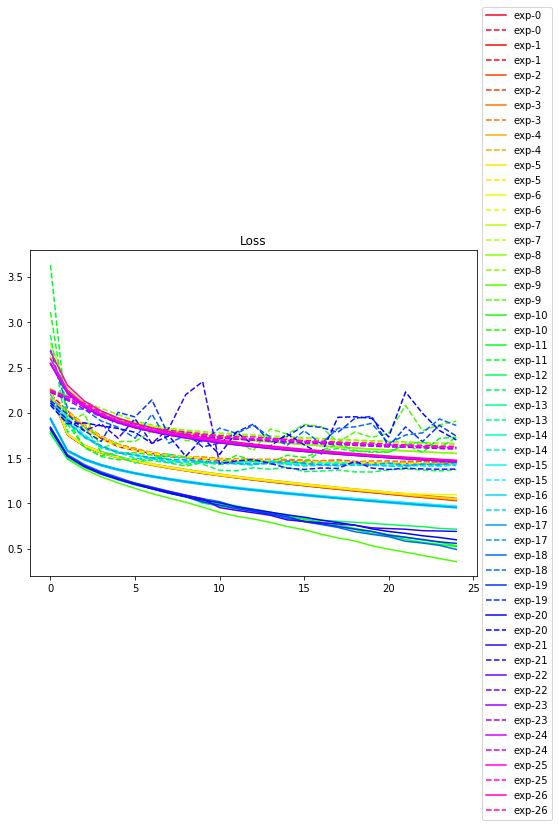

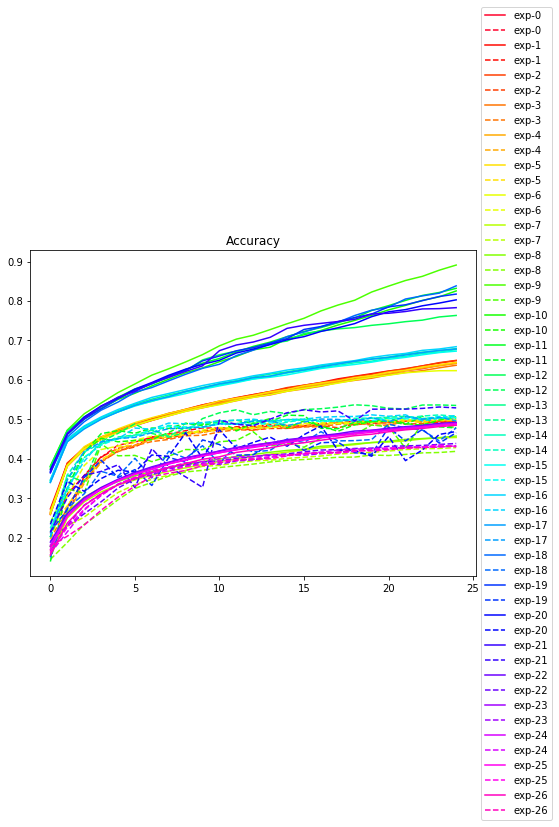

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()